In [1]:
train_dir = "Train data path" 
valid_dir = "Validation data path"
test_dir = "Test data path" 

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization
from keras.models import Sequential
import datetime

In [3]:
vgg_model = vgg16.VGG16(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))

In [4]:
vgg_model.trainable = True
for layer in vgg_model.layers[:15]:
    layer.trainable = False

In [5]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
num_classes = 3

output = vgg_model.output
output = Flatten()(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(512, activation = 'relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output) 
output = Dense(256, activation='relu')(output)
output = Dense(num_classes, activation='softmax')(output)

model = Model(inputs = vgg_model.input, outputs = output)

In [7]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1. /255)

test_datagen = ImageDataGenerator(rescale = 1. /255)

training_set = train_datagen.flow_from_directory(
        train_dir,
        target_size = (224, 224),
        batch_size = 25,
        class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory(
        valid_dir,
        target_size = (224, 224),
        batch_size = 25,
        class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
        test_dir,
        target_size = (224, 224),
        batch_size = 25,
        class_mode = 'categorical')

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('accuracy') >= 0.9975):
      print("Model stopped trainig")
      self.model.stop_training = True

initial_learning_rate = 0.01
n_epochs = 25
decay = initial_learning_rate / n_epochs

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

# early_stopping = EarlyStopping(monitor = 'val_accuracy', verbose = 0, mode = 'auto', restore_best_weights = True)
model_ckpt = ModelCheckpoint("/ckpts/", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
cb = myCallback()
# callbacks = [cb, early_stopping, model_ckpt, LearningRateScheduler(lr_time_based_decay, verbose = 1)]
callbacks = [cb, model_ckpt, LearningRateScheduler(lr_time_based_decay, verbose = 1)]

In [9]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
history = model.fit(
        training_set,
        steps_per_epoch = 80,
        epochs = n_epochs,
        validation_data = validation_set,
        validation_steps = 6,
        callbacks = callbacks
        )


Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/25
80/80 [==============================] - 343s 4s/step - loss: 1.0095 - accuracy: 0.6255 - val_loss: 2.2553 - val_accuracy: 0.3333

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00999600137593221.
Epoch 2/25
80/80 [==============================] - 335s 4s/step - loss: 0.8402 - accuracy: 0.6675 - val_loss: 1.1265 - val_accuracy: 0.5133

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009988011199709991.
Epoch 3/25
80/80 [==============================] - 333s 4s/step - loss: 0.7889 - accuracy: 0.6805 - val_loss: 1.0125 - val_accuracy: 0.5867

Epoch 00004: LearningRateScheduler reducing learning rate to 0.009976039613443424.
Epoch 4/25
80/80 [==============================] - 333s 4s/step - loss: 0.7245 - accuracy: 0.7005 - val_loss: 1.2520 - val_accuracy: 0.5733

Epoch 00005: LearningRateScheduler reducing learning rate to 0.009960103475045376.
Epoch 5/25
80/80 

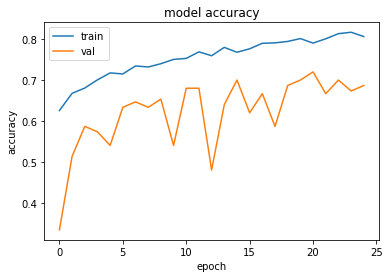

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

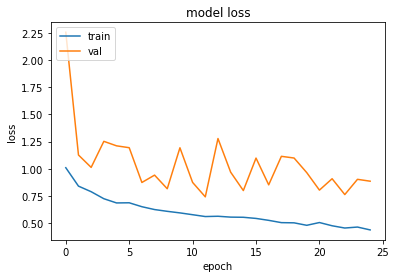

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
filenames = test_set.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_set, steps = nb_samples)

Instructions for updating:
Please use Model.predict, which supports generators.


In [14]:
from sklearn.metrics import confusion_matrix
import numpy as np

pred_labels = list(np.argmax(predict, axis=-1))
true_labels = test_set.classes

cm = confusion_matrix(true_labels, pred_labels)
print(cm)

[[  3  54  60]
 [ 14 231 148]
 [  4  50  36]]
